Clustering tree morphologies on the basis of topology via [Persistent Homology](https://en.wikipedia.org/wiki/Topological_data_analysis)

The distance metric is pairwise bottleneck distances between persistence diagrams generated from sub-level set filtrations over neuronal morphologies.

See [Li Y, Wang D, Ascoli GA, Mitra P, Wang Y (2017) Metrics for comparing neuronal tree shapes based on persistent homology. PLoS ONE](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0182184) 

for the general approach

In [1]:
import time
import imagej
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, ward, complete, average

In [2]:
# Initialize Fiji with GUI support.
ij = imagej.init(r'C:\Users\cam\Desktop\My_Desktop\Fiji.app', headless=False)
from jnius import autoclass, cast

In [3]:
Context = autoclass('org.scijava.Context')
Tree = autoclass('sc.fiji.snt.Tree')
MouseLightLoader = autoclass('sc.fiji.snt.io.MouseLightLoader')
PersistenceAnalyzer = autoclass('sc.fiji.snt.analysis.PersistenceAnalyzer')
Viewer2D = autoclass('sc.fiji.snt.viewer.Viewer2D')
Viewer3D = autoclass('sc.fiji.snt.viewer.Viewer3D')

MultiViewer2D = autoclass('sc.fiji.snt.viewer.MultiViewer2D')
MultiTreeColorMapper = autoclass('sc.fiji.snt.analysis.MultiTreeColorMapper')
ColorTables = autoclass('net.imagej.display.ColorTables')

In [4]:
diagram_map = {}  # global
tree_map = {}     # global
labels = []       # global

In [5]:
def mydist(a1, a2):
    # bottleneck distance between two persistence diagrams
    # an epsilon may be specified, which greatly accelerates the computation
    return gd.bottleneck_distance(diagram_map[a1[0]], diagram_map[a2[0]]) 


def get_distance_matrix(cell_ids):
    M = pairwise_distances(cell_ids, metric=mydist)
    
    return M

    
def fetch_reconstructions():
    # Two types of mouse PT neuron from MOs with differing projection patterns descbried in 
    # Economo et al. Nature 2018
    # Group 0 contains the Medulla projecting sub-type. 
    # Group 1 contains the Thalamic projecting sub-type.
    # pre print at https://www.biorxiv.org/content/biorxiv/early/2017/12/05/229260.full.pdf
    group_0 = ['AA0011', 'AA0012', 'AA0115', 'AA0179', 'AA0180', 'AA0181', 'AA0182', 'AA0245', 
              'AA0250', 'AA0576', 'AA0726', 'AA0788', 'AA0791', 'AA0792']
    group_1 = ['AA0039', 'AA0101', 'AA0103', 'AA0105', 'AA0188', 'AA0278', 'AA0390', 'AA0394', 
              'AA0406', 'AA0577', 'AA0599', 'AA0633', 'AA0650', 'AA0781', 'AA0784', 'AA0799', 
              'AA0817', 'AA0837', 'AA0838', 'AA0844']
#     group_2 = ['AA0444', 'AA0490', 'AA0491', 'AA0560', 'AA0611', 'AA0688', 'AA0731', 'AA0804', 
#               'AA0810', 'AA0823', 'AA0827', 'AA0828']
#     group_3 = ['AA0380', 'AA0383', 'AA0423', 'AA0459', 'AA0687', 'AA0704', 'AA0721', 'AA0736', 
#               'AA0811', 'AA0824', 'AA0847', 'AA0848', 'AA0849', 'AA0855']
    groups = [group_0, group_1]
    trees = []
    for num, group in enumerate(groups):
        for cell in group:
            loader = MouseLightLoader(cell)
            if not loader.isDatabaseAvailable(): 
                print("Database not available. Exiting...")
                return
            if not loader.idExists(): 
                print("Id not found in database. Exiting...")
                return
            # Only compare axon topologies
            tree = loader.getTree('axon')
            trees.append(tree)
            tree_map[tree.getLabel()[0:6]] = tree
            tree.setLabel(tree.getLabel().replace('.swc', '') + ' group: ' + str(num))
            labels.append(tree.getLabel())
            
    return trees
    
    
def compute(groups):
    cell_ids = []
    for tree in trees:  
        # Obtain Persistence Diagram as an nx2 array where each row corresponds
        # to one birth-death interval.
        diagram = np.asarray(ij.py.from_java(PersistenceAnalyzer(tree).getPersistenceDiagram()))
        key = int(tree.getLabel()[2:6])  # just the numeric part
        diagram_map[key] = diagram
        # necessary to pass a 2D numeric array to sklearn.metrics.pairwise_distances
        cell_ids.append([key])
    t0 = time.time()
    matrix = get_distance_matrix(cell_ids)
    t1 = time.time()
    print(t1-t0, ' seconds to compute all distances')

    return matrix

In [6]:
trees = fetch_reconstructions()

In [7]:
matrix = compute(trees)

11.624516248703003  seconds to compute all distances


[[   0.         4057.84478576 2064.25622643 ... 5351.52642489
  5042.40258092 4437.58778457]
 [4057.84478576    0.         4748.68339812 ... 8521.49836803
  8521.49836803 8495.43257033]
 [2064.25622643 4748.68339812    0.         ... 4660.68781254
  4351.56396856 3746.74917222]
 ...
 [5351.52642489 8521.49836803 4660.68781254 ...    0.
   838.0871486  1294.10435838]
 [5042.40258092 8521.49836803 4351.56396856 ...  838.0871486
     0.          759.56947043]
 [4437.58778457 8495.43257033 3746.74917222 ... 1294.10435838
   759.56947043    0.        ]]
[ 4057.84478576  2064.25622643  4647.06312349  5011.59257356
  3014.46570843  2977.75517141  1553.3945697   2261.06703347
  3512.24312197  3047.95538113  9644.98357328  2410.04352577
  2852.32884375  5879.16726736  5110.56349183  3619.77289909
  5347.30602343  5393.06395272  3413.65568885  3413.65568885
  3413.65568885  3470.82357002  5492.92348775  5503.67540657
  4928.20235198  3672.81560729  4964.62120524  3413.65568885
  5486.5441612   5

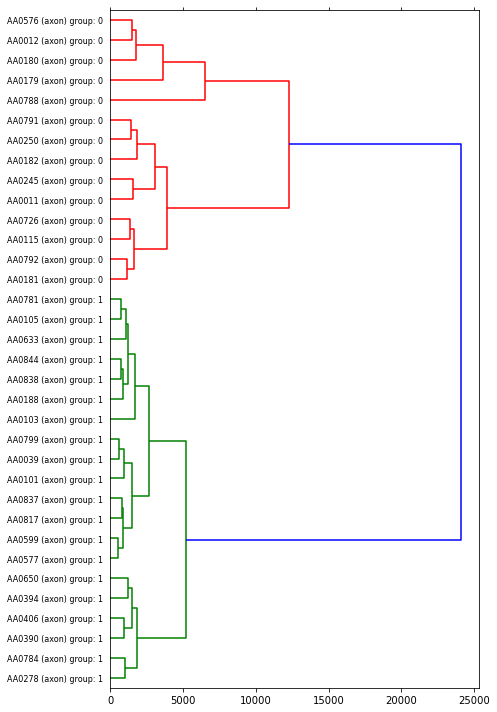

In [8]:
# Perform Hierarchical Clustering on the bottleneck distance matrix and plot a dendrogram
# of the resulting linkage matrix

# compensate for floating point errors in the bottleneck distance computation
np.fill_diagonal(matrix, 0) 
# convert to n-choose-2 dimensional vector to pass to linkage function
mat_arr = squareform(matrix)
print(matrix)
print(mat_arr)
linkage_matrix = ward(mat_arr) #define linkage_matrix using Ward's method

fig, ax = plt.subplots(figsize=(7, 10)) # set size
dendrogram(linkage_matrix, orientation='right', labels=labels) 
plt.tick_params(\
    axis= 'x',         # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')
plt.tight_layout()
#plt.savefig('ward_clusters.png', dpi=200)

Lets plot the two neighboring cells in each family

[[0.         0.35862311 0.18243428 ... 0.47295576 0.44563609 0.39218393]
 [0.35862311 0.         0.41967786 ... 0.75311068 0.75311068 0.75080704]
 [0.18243428 0.41967786 0.         ... 0.41190101 0.38458134 0.33112919]
 ...
 [0.47295576 0.75311068 0.41190101 ... 0.         0.07406824 0.11437001]
 [0.44563609 0.75311068 0.38458134 ... 0.07406824 0.         0.06712903]
 [0.39218393 0.75080704 0.33112919 ... 0.11437001 0.06712903 0.        ]]
(34, 34)
Estimated number of clusters: 1
Estimated number of noise points: 1
Homogeneity: 0.038
Completeness: 1.000
V-measure: 0.073
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000


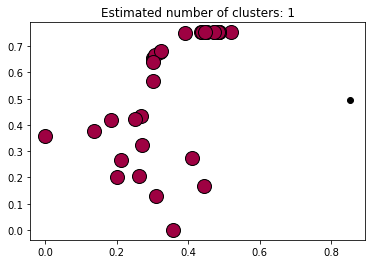

In [9]:

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
labels_true = labels
X = matrix / np.max(matrix)
print(X)
print(X.shape)
# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=3500, min_samples=5, metric='precomputed').fit(matrix)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
dblabels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(dblabels)) - (1 if -1 in dblabels else 0)
n_noise_ = list(dblabels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, dblabels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, dblabels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, dblabels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, dblabels))
print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(labels_true, dblabels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(dblabels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (dblabels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

def get_group_viewers(compare):
    viewers = []
    for pair in compare:
        true_labels = []
        v = Viewer3D()
        for t in pair:
            v.addTree(tree_map[t])
            true_labels.append(tree_map[t].getLabel())
            
        v.colorCode(ij.py.to_java(true_labels), 
                    MultiTreeColorMapper.LENGTH, 
                    ColorTables.ICE)
        #v.setViewMode(Viewer3D.ViewMode.SIDE)
        viewers.append(v)
        
    return viewers



In [10]:
compare = [['AA0576', 'AA0012'], ['AA0784', 'AA0278']]
viewers = get_group_viewers(compare)  

In [11]:
viewers[0].show()
viewers[1].show()

<java.awt.Frame at 0x273a9af7fa8 jclass=java/awt/Frame jself=<LocalRef obj=0x-65681b90 at 0x273a1287d30>>